<a href="https://colab.research.google.com/github/shrprabh/BraTS-PolypSegmentation/blob/4-calculate-sensitivity-recall-specificity-and-evaluate-the-model/polysegmentationofbradtsdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install nibabel for handling NIfTI files


In [3]:
!pip install nibabel

# Import libraries


In [4]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     BatchNormalization, Activation, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# importing files files package to upload a file to get the dataset

In [5]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shrprabh","key":"323ee59f3e2f0c11df48be77bdb30712"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d awsaf49/brats2020-training-data


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
100% 6.75G/6.76G [01:00<00:00, 139MB/s]
100% 6.76G/6.76G [01:00<00:00, 120MB/s]


In [7]:
!kaggle datasets download -d awsaf49/brats2020-training-data
!unzip -qq brats2020-training-data.zip -d brats2020


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
brats2020-training-data.zip: Skipping, found more recently modified local copy (use --force to force download)


#Step 3: Data Preprocessing
#Load the images and masks, extract slices, and prepare them for training.#

#load libraries

In [8]:
import os
import h5py
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose,
                                     BatchNormalization, Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec  6 00:58:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Define your data directory



In [10]:
data_dir = 'brats2020/BraTS2020_training_data/content/data/'


# Initialize lists to store image and mask slices


Input images shape (X): (3809, 256, 256, 4)
Mask images shape (y): (3809, 256, 256, 1)
Training images shape (X_train): (3047, 256, 256, 4)
Training masks shape (y_train): (3047, 256, 256, 1)
Validation images shape (X_val): (762, 256, 256, 4)
Validation masks shape (y_val): (762, 256, 256, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 256, 256, 32)   │          1,184 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 256, 256, 32)   │            128 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_27             │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_22            │ (None, 256, 256, 36)   │              0 │ input_layer_1[0][0],   │
│ (Concatenate)             │                        │                │ activation_27[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 256, 256, 32)   │         10,400 │ concatenate_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 256, 256, 32)   │            128 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_28             │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_23            │ (None, 256, 256, 68)   │              0 │ input_layer_1[0][0],   │
│ (Concatenate)             │                        │                │ activation_27[0][0],   │
│                           │                        │                │ activation_28[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 256, 256, 32)   │         19,616 │ concatenate_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 256, 256, 32)   │            128 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_29             │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 32)   │              0 │ activation_29[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├──────────────────────

 Total params: 21,900,737 (83.54 MB)

 Trainable params: 21,891,905 (83.51 MB)

 Non-trainable params: 8,832 (34.50 KB)

Epoch 1/300
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9663 - dice_coefficient: 0.1657 - loss: 0.2618 - mean_iou_metric: 0.5500 - precision_metric: 0.6874 - sensitivity_metric: 0.7623 - specificity_metric: 0.9747
Epoch 1: val_loss improved from inf to 0.17163, saving model to ducknet_brats.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 100s 188ms/step - accuracy: 0.9664 - dice_coefficient: 0.1658 - loss: 0.2617 - mean_iou_metric: 0.5502 - precision_metric: 0.6877 - sensitivity_metric: 0.7623 - specificity_metric: 0.9747 - val_accuracy: 0.9826 - val_dice_coefficient: 0.1305 - val_loss: 0.1716 - val_mean_iou_metric: 0.3444 - val_precision_metric: 0.9782 - val_sensitivity_metric: 0.3472 - val_specificity_metric: 0.9998
Epoch 2/300
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9891 - dice_coefficient: 0.2610 - loss: 0.1194 - mean_iou_metric: 0.6974 - precision_metric: 0.8545 - sensitivity_metric: 0.7964 - specificity_metric: 0.9966
Epoch 2: val_loss improved from 0.17163 to 0.

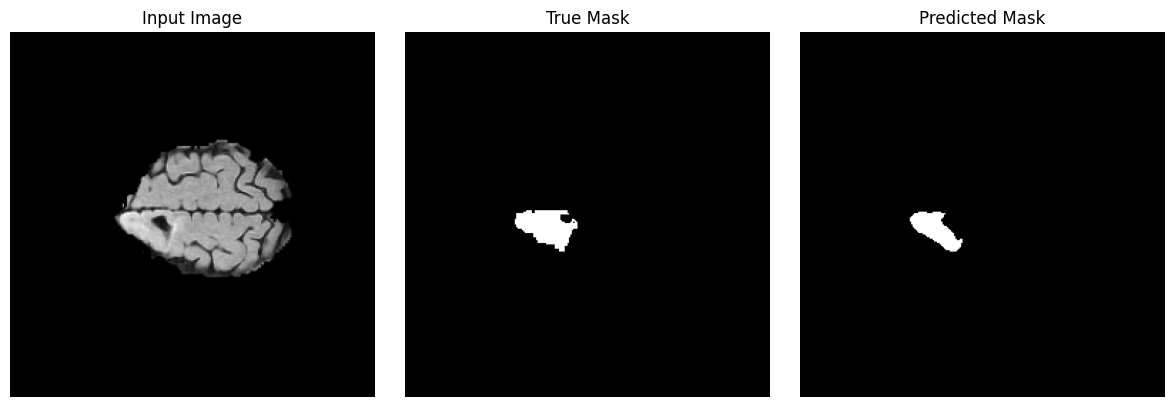

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


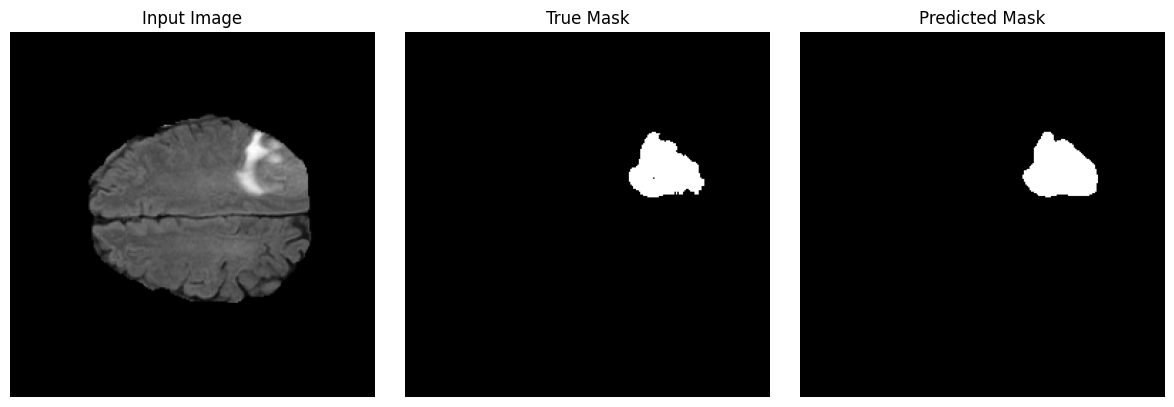

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


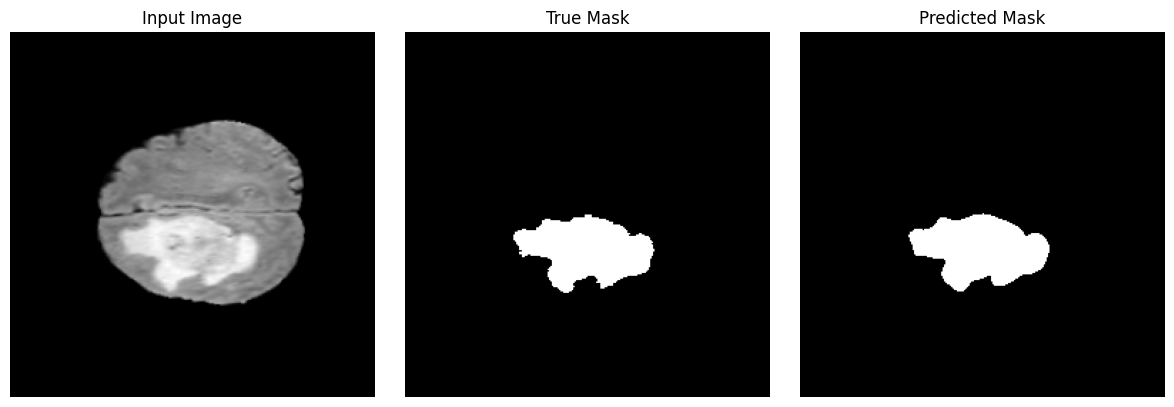

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


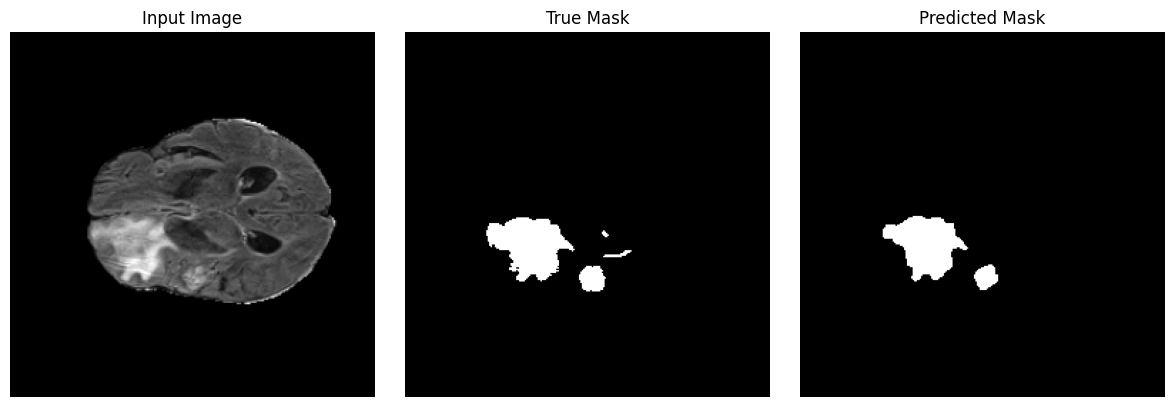

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


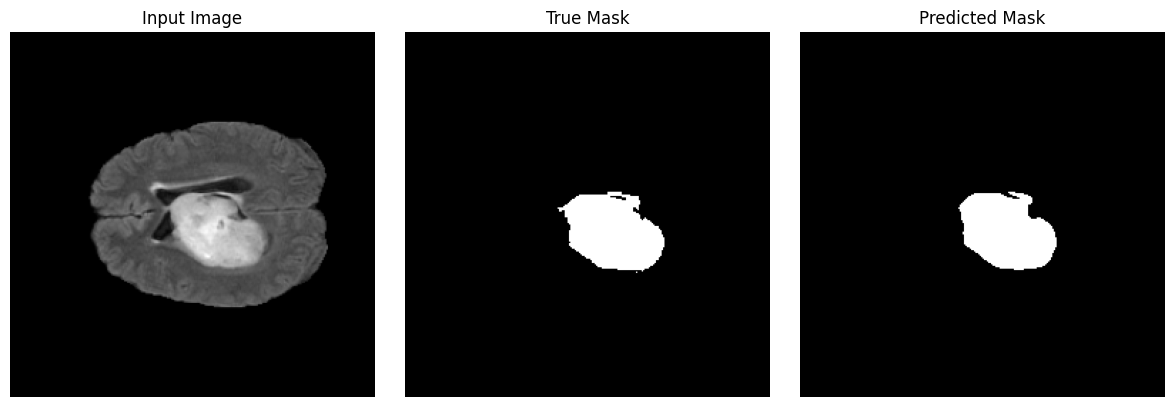

In [12]:
import os
import numpy as np
import h5py
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     BatchNormalization, Activation, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def dice_coefficient(y_true, y_pred, smooth=1.0):
    """
    Dice Coefficient = 2 * (|X ∩ Y|) / (|X| + |Y|)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision_metric(y_true, y_pred, threshold=0.5):
    """
    Precision = TP / (TP + FP)
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    tp = K.sum(y_true * y_pred_bin)
    fp = K.sum((1 - y_true) * y_pred_bin)
    precision = tp / (tp + fp + K.epsilon())
    return precision

def sensitivity_metric(y_true, y_pred, threshold=0.5):
    """
    Sensitivity (Recall) = TP / (TP + FN)
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    tp = K.sum(y_true * y_pred_bin)
    fn = K.sum(y_true * (1 - y_pred_bin))
    sensitivity = tp / (tp + fn + K.epsilon())
    return sensitivity

def specificity_metric(y_true, y_pred, threshold=0.5):
    """
    Specificity = TN / (TN + FP)
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    tn = K.sum((1 - y_true) * (1 - y_pred_bin))
    fp = K.sum((1 - y_true) * y_pred_bin)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

def mean_iou_metric(y_true, y_pred, threshold=0.5):
    """
    Mean IoU for binary segmentation:
    IoU = |X ∩ Y| / (|X ∪ Y|)
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    intersection = K.sum(y_true * y_pred_bin)
    union = K.sum(y_true) + K.sum(y_pred_bin) - intersection
    iou = intersection / (union + K.epsilon())
    return iou
# Check for GPU availability
if not tf.config.list_physical_devices('GPU'):
    print("No GPU found. Training will be slow.")

# Define the data directory and initialize lists for images and masks
data_dir = 'brats2020/BraTS2020_training_data/content/data/'  # Update this path as needed
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The data directory {data_dir} does not exist.")

image_slices = []
mask_slices = []

# Load and preprocess data
file_list = [f for f in os.listdir(data_dir) if f.endswith('.h5')][:9000]
for file_name in file_list:
    file_path = os.path.join(data_dir, file_name)
    with h5py.File(file_path, 'r') as f:
        img_slice = np.array(f['image'])
        mask_slice = np.array(f['mask'])

        # Skip slices without any mask
        if np.max(mask_slice) == 0:
            continue

        # Normalize the image slice
        epsilon = 1e-8
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + epsilon)

        # Resize images and masks to 256x256
        img_resized = cv2.resize(img_slice, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask_slice, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Convert masks to single-channel binary
        if mask_resized.ndim == 3:
            mask_resized = np.any(mask_resized, axis=-1).astype(np.float32)

        # Expand dimensions for images if necessary
        if img_resized.ndim == 2:
            img_resized = np.expand_dims(img_resized, axis=-1)

        # Expand dimensions for masks if necessary
        if mask_resized.ndim == 2:
            mask_resized = np.expand_dims(mask_resized, axis=-1)

        image_slices.append(img_resized)
        mask_slices.append(mask_resized)

# Convert lists to numpy arrays
X = np.array(image_slices, dtype=np.float32)
y = np.array(mask_slices, dtype=np.float32)

# Debugging: Print data shapes
print(f"Input images shape (X): {X.shape}")
print(f"Mask images shape (y): {y.shape}")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Debugging: Print split data shapes
print(f"Training images shape (X_train): {X_train.shape}")
print(f"Training masks shape (y_train): {y_train.shape}")
print(f"Validation images shape (X_val): {X_val.shape}")
print(f"Validation masks shape (y_val): {y_val.shape}")

# Data augmentation settings
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=90,
                     fill_mode='nearest')
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Define batch size
batch_size = 8

# Training generator function
def train_generator(X_train_data, y_train_data, batch_size):
    seed_value = 42
    image_generator = image_datagen.flow(X_train_data, batch_size=batch_size, seed=seed_value)
    mask_generator = mask_datagen.flow(y_train_data, batch_size=batch_size, seed=seed_value)
    while True:
        img = next(image_generator)
        mask = next(mask_generator)
        yield (img, mask)

train_gen = train_generator(X_train, y_train, batch_size=batch_size)

# Define DUCKNet architecture with dense blocks
def dense_block(x, filters):
    conv1 = Conv2D(filters, 3, padding='same')(x)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)
    concat1 = Concatenate()([x, act1])
    conv2 = Conv2D(filters, 3, padding='same')(concat1)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(bn2)
    concat2 = Concatenate()([x, act1, act2])
    conv3 = Conv2D(filters, 3, padding='same')(concat2)
    bn3 = BatchNormalization()(conv3)
    act3 = Activation('relu')(bn3)
    return act3

def DUCKNet(input_size=(256, 256, 4)):  # Support 4-channel input
    inputs = Input(input_size)
    db1 = dense_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    db2 = dense_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    db3 = dense_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)
    db4 = dense_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)
    db5 = dense_block(pool4, 512)
    up6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(db5)
    merge6 = Concatenate()([up6, db4])
    db6 = dense_block(merge6, 256)
    up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(db6)
    merge7 = Concatenate()([up7, db3])
    db7 = dense_block(merge7, 128)
    up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(db7)
    merge8 = Concatenate()([up8, db2])
    db8 = dense_block(merge8, 64)
    up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(db8)
    merge9 = Concatenate()([up9, db1])
    db9 = dense_block(merge9, 32)
    conv10 = Conv2D(1, 1, activation='sigmoid')(db9)
    model = Model(inputs=inputs, outputs=conv10)
    return model

# Build the model with input size adjusted for 4-channel input
model = DUCKNet(input_size=(256, 256, 4))

# Recompile the model to include the additional metrics
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        dice_coefficient,
        precision_metric,
        sensitivity_metric,
        specificity_metric,
        mean_iou_metric
    ]
)
# Display the model architecture
model.summary()

# Set up callbacks
callbacks = [
    ModelCheckpoint('ducknet_brats.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=300,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# Visualize Predictions
import random
num_samples = 5
indices = random.sample(range(X_val.shape[0]), num_samples)
for i in indices:
    input_image = X_val[i]
    true_mask = y_val[i]
    prediction = model.predict(input_image[np.newaxis, ...])[0, :, :, 0]
    prediction = (prediction > 0.5).astype(np.float32)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image[:, :, 0], cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask[:, :, 0], cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [15]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def dice_coefficient(y_true, y_pred, smooth=1.0):
    """
    Dice Coefficient = 2 * (|X ∩ Y|) / (|X| + |Y|)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision_metric(y_true, y_pred, threshold=0.5):
    """
    Precision = TP / (TP + FP)
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    tp = K.sum(y_true * y_pred_bin)
    fp = K.sum((1 - y_true) * y_pred_bin)
    precision = tp / (tp + fp + K.epsilon())
    return precision

def sensitivity_metric(y_true, y_pred, threshold=0.5):
    """
    Sensitivity (Recall) = TP / (TP + FN)
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    tp = K.sum(y_true * y_pred_bin)
    fn = K.sum(y_true * (1 - y_pred_bin))
    sensitivity = tp / (tp + fn + K.epsilon())
    return sensitivity

def specificity_metric(y_true, y_pred, threshold=0.5):
    """
    Specificity = TN / (TN + FP)
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    tn = K.sum((1 - y_true) * (1 - y_pred_bin))
    fp = K.sum((1 - y_true) * y_pred_bin)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

def mean_iou_metric(y_true, y_pred, threshold=0.5):
    """
    Mean IoU for binary segmentation:
    IoU = |X ∩ Y| / (|X ∪ Y|)
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    intersection = K.sum(y_true * y_pred_bin)
    union = K.sum(y_true) + K.sum(y_pred_bin) - intersection
    iou = intersection / (union + K.epsilon())
    return iou



In [16]:

# Recompile the model to include the additional metrics
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        dice_coefficient,
        precision_metric,
        sensitivity_metric,
        specificity_metric,
        mean_iou_metric
    ]
)

In [17]:
# Set up additional callbacks for better training management
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Set up additional callbacks for better training management
callbacks = [
    ModelCheckpoint('ducknet_brats_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Calculate steps per epoch
steps_per_epoch = len(X_train) // batch_size

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=160,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# Evaluate the model on the validation set (or test set)
results = model.evaluate(X_val, y_val, verbose=1)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

Epoch 1/160
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9925 - dice_coefficient: 0.8493 - loss: 0.0124 - mean_iou_metric: 0.8133 - precision_metric: 0.9122 - sensitivity_metric: 0.8834 - specificity_metric: 0.9979
Epoch 1: val_loss improved from inf to 0.01350, saving model to ducknet_brats_best.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 108s 214ms/step - accuracy: 0.9925 - dice_coefficient: 0.8493 - loss: 0.0124 - mean_iou_metric: 0.8133 - precision_metric: 0.9122 - sensitivity_metric: 0.8834 - specificity_metric: 0.9979 - val_accuracy: 0.9948 - val_dice_coefficient: 0.8573 - val_loss: 0.0135 - val_mean_iou_metric: 0.8165 - val_precision_metric: 0.9117 - val_sensitivity_metric: 0.8869 - val_specificity_metric: 0.9977 - learning_rate: 1.0000e-04
Epoch 2/160
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9927 - dice_coefficient: 0.8550 - loss: 0.0122 - mean_iou_metric: 0.8190 - precision_metric: 0.9144 - sensitivity_metric: 0.8882 - specificity_metric: 0.9979
Epoch 2: val

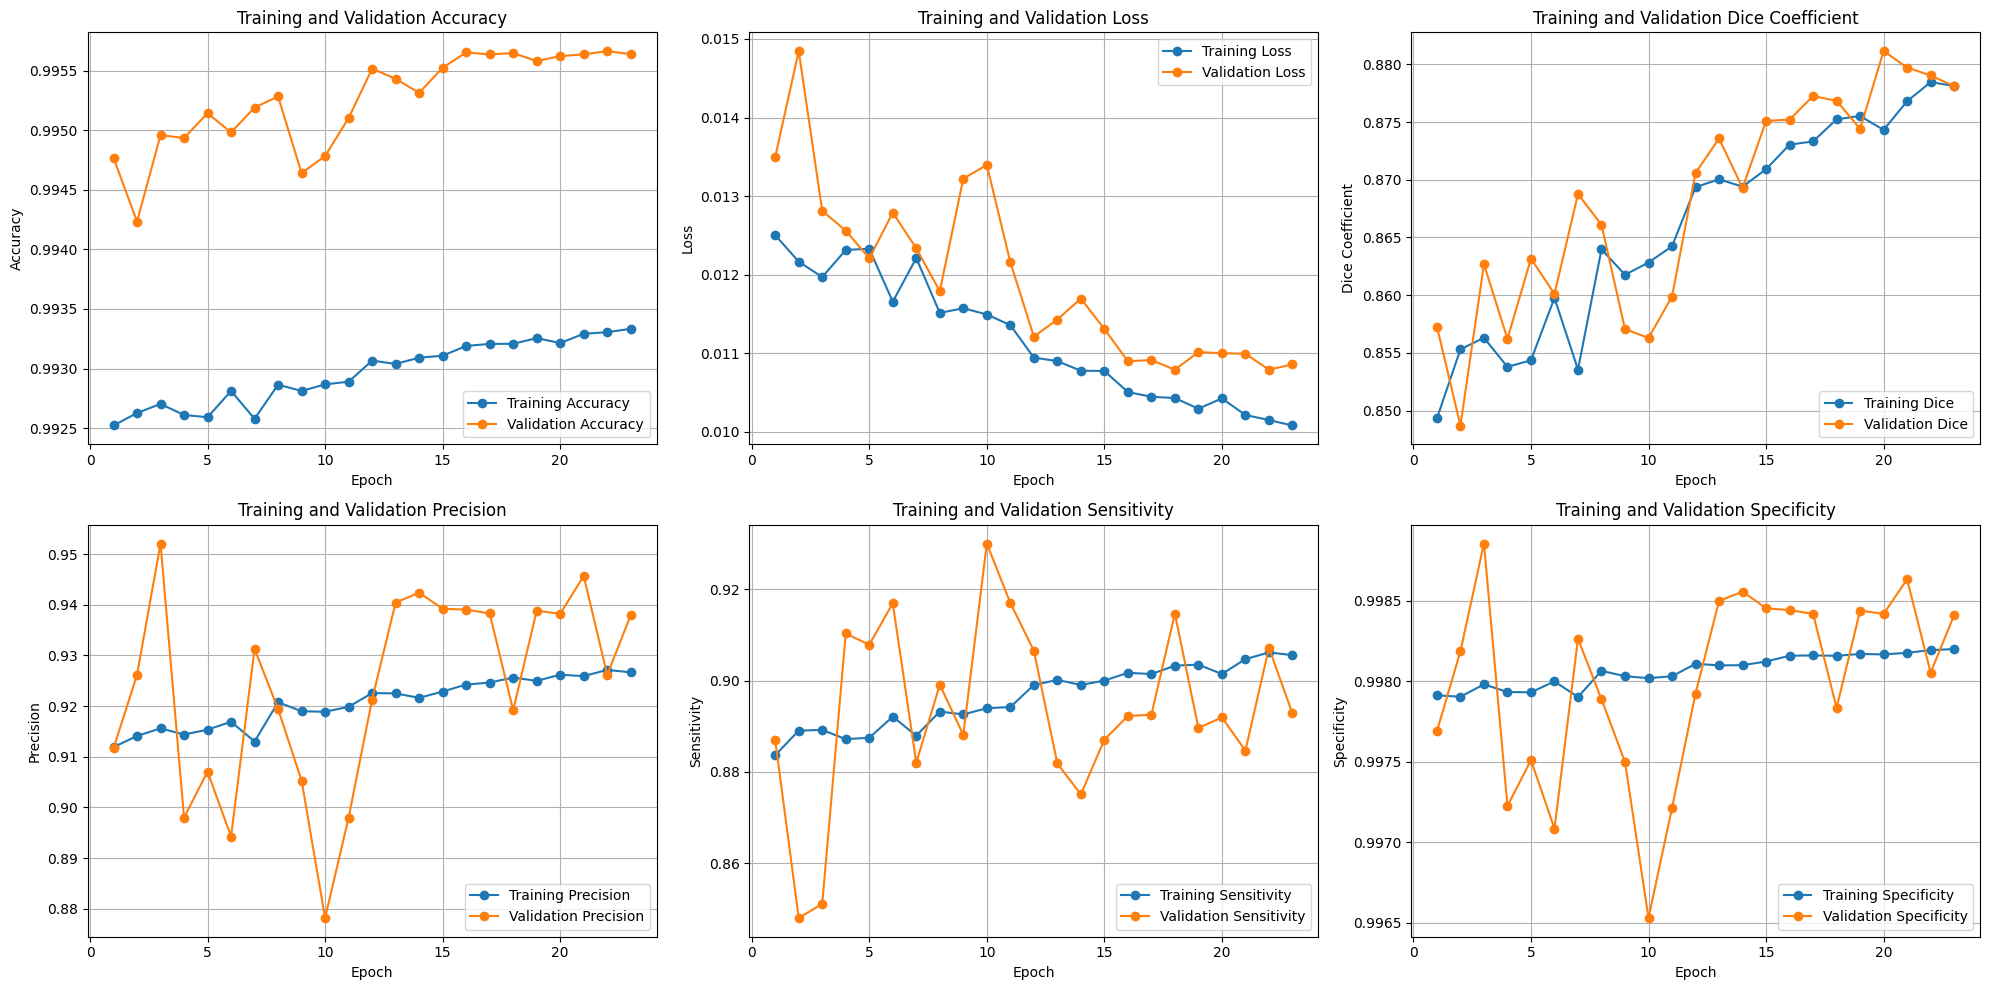

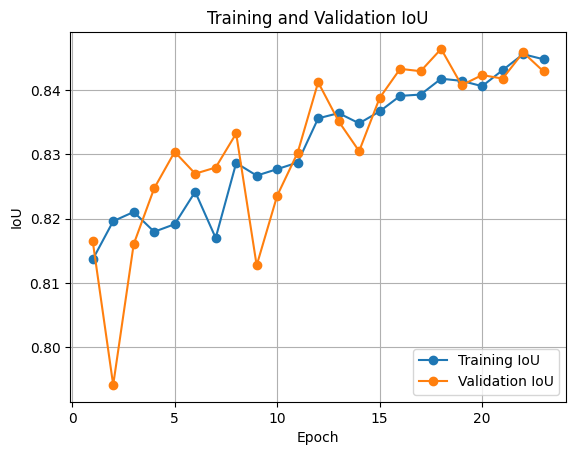

In [27]:
# Plotting as before
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

dice = history.history['dice_coefficient']
val_dice = history.history['val_dice_coefficient']

precision = history.history['precision_metric']
val_precision = history.history['val_precision_metric']

sensitivity = history.history['sensitivity_metric']
val_sensitivity = history.history['val_sensitivity_metric']

specificity = history.history['specificity_metric']
val_specificity = history.history['val_specificity_metric']

iou = history.history['mean_iou_metric']
val_iou = history.history['val_mean_iou_metric']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(epochs_range, dice, label='Training Dice', marker='o')
plt.plot(epochs_range, val_dice, label='Validation Dice', marker='o')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(epochs_range, precision, label='Training Precision', marker='o')
plt.plot(epochs_range, val_precision, label='Validation Precision', marker='o')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(epochs_range, sensitivity, label='Training Sensitivity', marker='o')
plt.plot(epochs_range, val_sensitivity, label='Validation Sensitivity', marker='o')
plt.title('Training and Validation Sensitivity')
plt.xlabel('Epoch')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(epochs_range, specificity, label='Training Specificity', marker='o')
plt.plot(epochs_range, val_specificity, label='Validation Specificity', marker='o')
plt.title('Training and Validation Specificity')
plt.xlabel('Epoch')
plt.ylabel('Specificity')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Plot IoU as well (if you want to visualize it separately)
plt.figure()
plt.plot(epochs_range, iou, label='Training IoU', marker='o')
plt.plot(epochs_range, val_iou, label='Validation IoU', marker='o')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [19]:
files.download('ducknet_brats_best.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import tensorflow as tf
from tensorflow.keras import backend as K

@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
import tensorflow as tf
from tensorflow.keras import backend as K

@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred, smooth=1):
    """
    Computes the Intersection over Union (IoU) metric.

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        float: IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


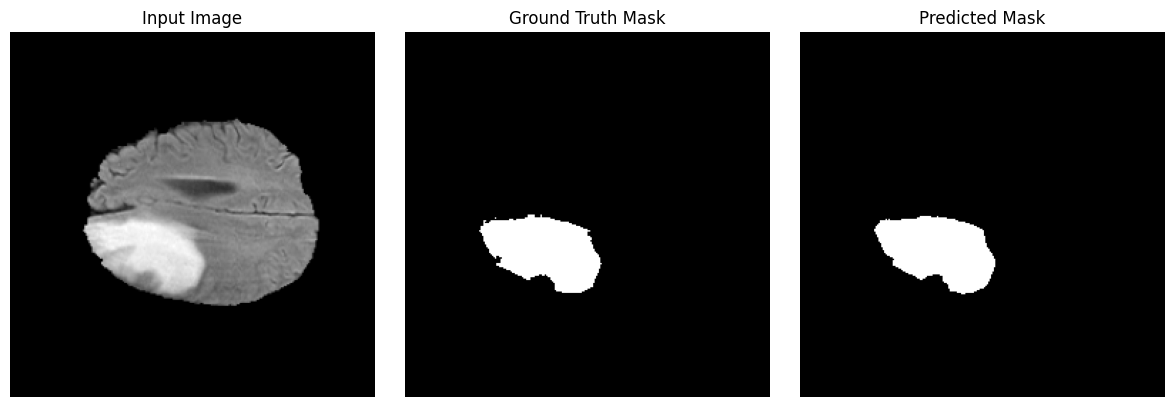

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


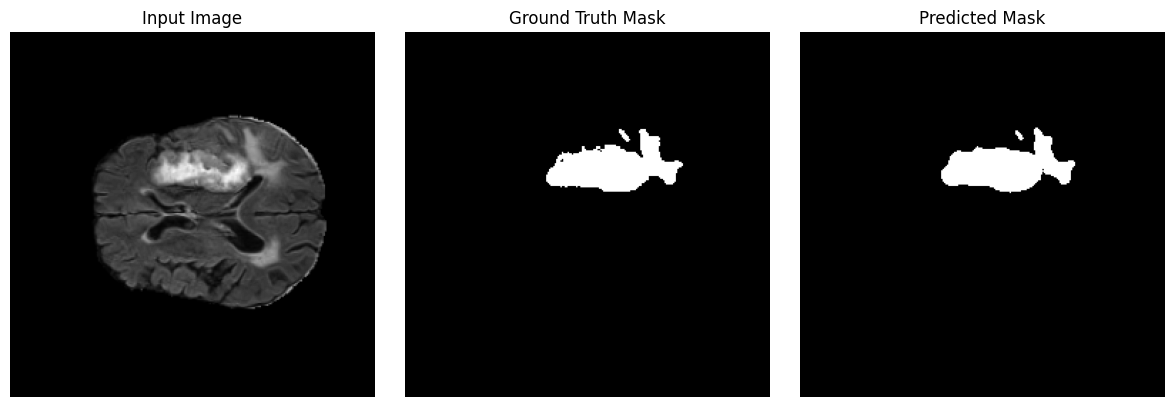

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


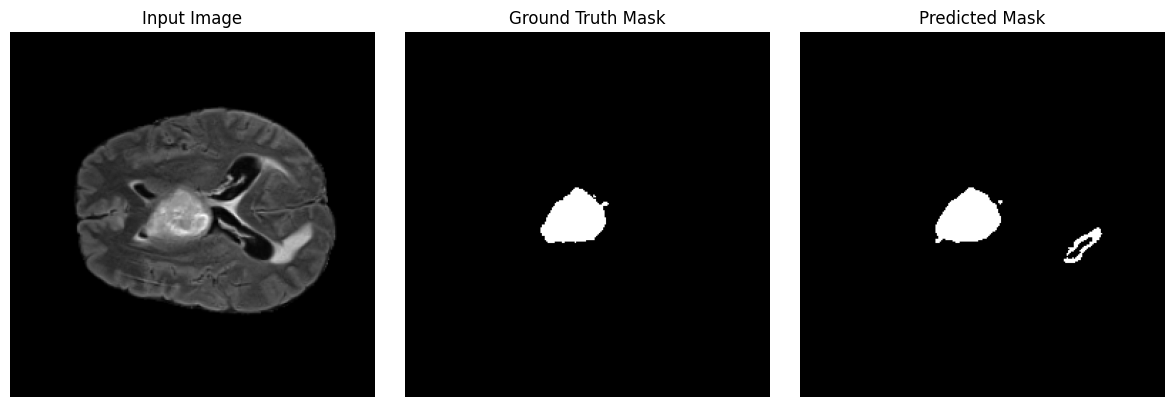

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


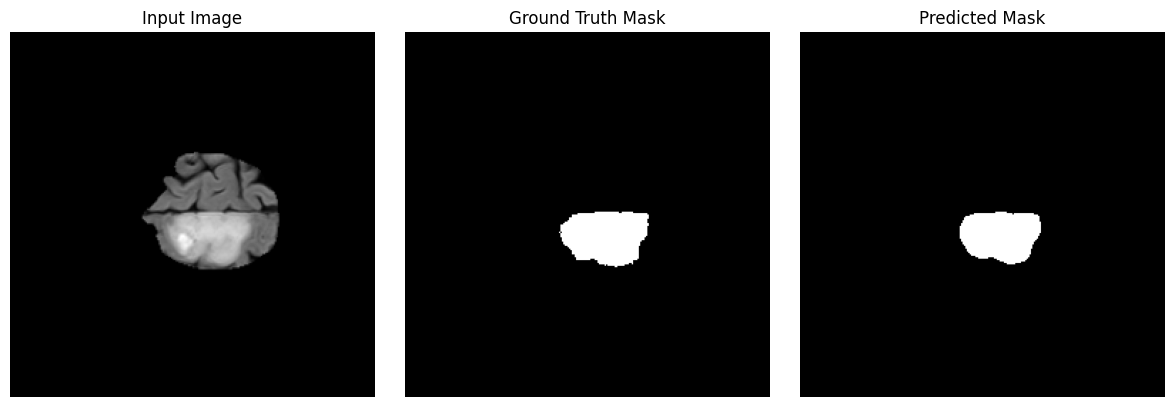

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


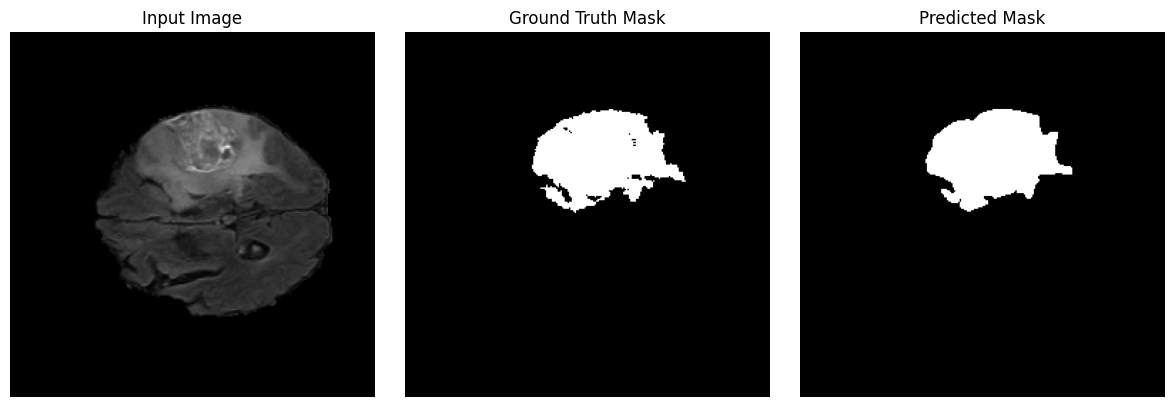

In [22]:
import random
import matplotlib.pyplot as plt

# Select a few random samples from the validation set
num_samples = 5  # Number of samples to visualize
random_indices = random.sample(range(X_val.shape[0]), num_samples)

# Iterate through selected samples
for idx in random_indices:
    # Get the input image, ground truth, and reshape for visualization
    input_image = X_val[idx]
    ground_truth_mask = y_val[idx]
    input_image_reshaped = input_image[:, :, 0] if input_image.shape[-1] > 1 else input_image[:, :, 0]

    # Add batch dimension and predict the mask
    input_image_batch = input_image[np.newaxis, ...]  # Add batch dimension
    predicted_mask = model.predict(input_image_batch)
    predicted_mask = predicted_mask[0, :, :, 0]  # Remove batch dimension and channel axis

    # Apply thresholding to the predicted mask
    predicted_mask = (predicted_mask > 0.5).astype(np.float32)

    # Display the image, ground truth, and prediction
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image_reshaped, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask[:, :, 0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [23]:
import os

output_dir = "output_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [24]:
import cv2

# Iterate through validation samples
for idx in range(len(X_val)):
    input_image = X_val[idx]
    ground_truth_mask = y_val[idx]
    predicted_mask = model.predict(input_image[np.newaxis, ...])[0, :, :, 0]
    predicted_mask = (predicted_mask > 0.5).astype(np.float32)

    # Save the input image
    input_image_path = os.path.join(output_dir, f"input_image_{idx}.png")
    input_image_rescaled = (input_image[:, :, 0] * 255).astype(np.uint8)  # Assuming 1-channel input
    cv2.imwrite(input_image_path, input_image_rescaled)

    # Save the ground truth mask
    ground_truth_path = os.path.join(output_dir, f"ground_truth_mask_{idx}.png")
    ground_truth_rescaled = (ground_truth_mask[:, :, 0] * 255).astype(np.uint8)
    cv2.imwrite(ground_truth_path, ground_truth_rescaled)

    # Save the predicted mask
    predicted_mask_path = os.path.join(output_dir, f"predicted_mask_{idx}.png")
    predicted_rescaled = (predicted_mask * 255).astype(np.uint8)
    cv2.imwrite(predicted_mask_path, predicted_rescaled)

print(f"Images saved in {output_dir}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [25]:
!zip -r output_images.zip output_images


  adding: output_images/ (stored 0%)
  adding: output_images/predicted_mask_537.png (deflated 68%)
  adding: output_images/input_image_454.png (deflated 3%)
  adding: output_images/predicted_mask_43.png (deflated 43%)
  adding: output_images/ground_truth_mask_62.png (deflated 35%)
  adding: output_images/input_image_16.png (deflated 3%)
  adding: output_images/ground_truth_mask_347.png (deflated 48%)
  adding: output_images/ground_truth_mask_448.png (deflated 46%)
  adding: output_images/ground_truth_mask_317.png (deflated 37%)
  adding: output_images/predicted_mask_22.png (deflated 56%)
  adding: output_images/ground_truth_mask_167.png (deflated 28%)
  adding: output_images/predicted_mask_204.png (deflated 29%)
  adding: output_images/ground_truth_mask_146.png (deflated 49%)
  adding: output_images/ground_truth_mask_397.png (deflated 60%)
  adding: output_images/ground_truth_mask_150.png (deflated 52%)
  adding: output_images/predicted_mask_222.png (deflated 27%)
  adding: output_imag

In [26]:
from google.colab import files
files.download("output_images.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>